# Hard Attention MNIST

This is jupyter notebook for `Hard Attention` from paper [Show, Attend and Tell](https://arxiv.org/abs/1502.03044). 
<br>This Algorithm will be tested by `Modified MNIST dataset` Which is made by [Jongwon Park](https://github.com/jwpark116). <br>This modified MNIST dataset is good for verifying attention algorithm.
<br>You can download modified MNIST data from this link
<br>[Training dataset](https://www.dropbox.com/s/e7jxyulxx2anqyq/MNIST_data_train_re.mat?dl=0)  /  [Testing dataset](https://www.dropbox.com/s/fcw4754bavva9my/MNIST_data_test_re.mat?dl=0)

# TENSORFLOW 1

In [1]:
# Import modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import skimage.transform
import cv2
import os

/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
print(tf.version.VERSION)

1.14.0


In [3]:
print(tf.test.is_gpu_available())

False


In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

train_y = to_categorical(train_y, 10)
test_y = to_categorical(test_y, 10)

print(train_x.shape, train_y.shape)
train_x = np.expand_dims(train_x, axis=3)
test_x = np.expand_dims(test_x, axis=3)
print(train_x.shape, train_y.shape)

print("Train data shape: " + str(train_x.shape))
print("Train label shape: " + str(train_y.shape))
print("Test data shape: " + str(test_x.shape))
print("Test label shape: " + str(test_y.shape))
print(np.max(test_x), np.min(test_x))

(60000, 28, 28) (60000, 10)
(60000, 28, 28, 1) (60000, 10)
Train data shape: (60000, 28, 28, 1)
Train label shape: (60000, 10)
Test data shape: (10000, 28, 28, 1)
Test label shape: (10000, 10)
1.0 0.0


## Parameters

In [5]:
# Parameters 
img_size = train_x.shape[1]
img_flat_size = img_size * img_size

# If you want to train the model -> True, otherwise -> False
Is_train = True

# If you want to load saved model -> True, otherwise -> False 
Load_model = False

# Name of the save file
save_path = 'saved_models/fashion_hard/'
if not os.path.exists(save_path):
  os.makedirs(save_path)

# Numbers of sampling to test the code 
num_test_sample = 50

# labels: 0 - 9
num_label = 10

# Parameters for training
num_epoch = 10

learning_rate = 5e-4
epsilon = 1e-8

batch_size = 256

# Parameter for LSTM
lstm_size = 256
step_size = 4
flatten_size = img_size

gpu_fraction = 0.3

## Plotting Sample Image (Modified MNIST for Attention)

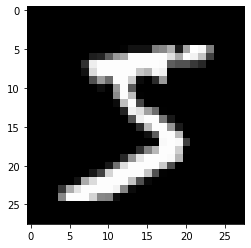

Label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Shape: 28x28


In [6]:
# Plotting example image
img = train_x[0, :, :]

plt.imshow(img, cmap = 'gray')
plt.show()
print('Label: ' + str(train_y[0,:]))
print('Shape: ' + str(img_size) + 'x' + str(img_size))

## Functions for Convolutional Network

In [7]:
# Initialize weights and bias 
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# Get Variables
def weight_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

## LSTM and Attention function

In [8]:
# Reset the graph
tf.reset_default_graph()

# LSTM function
def LSTM_cell(C_prev, h_prev, x_lstm, Wf, Wi, Wc, Wo, bf, bi, bc, bo):
    # C_prev: Cell state from lstm of previous time step (shape: [batch_size, lstm_size])
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # x_lstm: input of lstm (shape: [batch_size, data_flatten_size])

    input_concat = tf.concat([x_lstm, h_prev], 1)
    f = tf.sigmoid(tf.matmul(input_concat, Wf) + bf)
    i = tf.sigmoid(tf.matmul(input_concat, Wi) + bi)
    c = tf.tanh(tf.matmul(input_concat, Wc) + bc)
    o = tf.sigmoid(tf.matmul(input_concat, Wo) + bo)
    
    C_t = tf.multiply(f, C_prev) + tf.multiply(i, c) 
    h_t = tf.multiply(o, tf.tanh(C_t))
    
    return C_t, h_t # Cell state, Output

# Hard Attention function
def hard_attention(h_prev, a, Wa, Wh):
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # a: Result of CNN [batch_size, conv_size * conv_size, channel_size] 

    m_list = [tf.tanh(tf.matmul(a[i], Wa) + tf.matmul(h_prev, Wh)) for i in range(len(a))] 
    m_concat = tf.concat([m_list[i] for i in range(len(a))], axis = 1)     
    alpha = tf.nn.softmax(m_concat) 
    
    #For Monte-Carlo Sampling
    alpha_cumsum = tf.cumsum(alpha, axis = 1)
    len_batch = tf.shape(alpha_cumsum)[0]
    rand_prob = tf.random_uniform(shape = [len_batch, 1], minval = 0., maxval = 1.)
    alpha_relu = tf.nn.relu(rand_prob - alpha_cumsum)
    alpha_index = tf.count_nonzero(alpha_relu, 1)
    alpha_hard  = tf.one_hot(alpha_index, len(a))

    z_list = [tf.multiply(a[i], tf.slice(alpha_hard, (0, i), (-1, 1))) for i in range(len(a))]
    z_stack = tf.stack(z_list, axis = 2)
    z = tf.reduce_sum(z_stack, axis = 2)

    return alpha, z
    

## Network

In [9]:
# Network

# Input 
x_image  = tf.placeholder(tf.float32, shape = [None, img_size, img_size, 1])
y_target = tf.placeholder(tf.float32, shape=[None, num_label])

# Convolution variables
w_conv1 = weight_variable('W_conv1', [3, 3, 1, 64])
b_conv1 = bias_variable('b_conv1', [64])
w_conv2 = weight_variable('W_conv2', [3, 3, 64, 256])
b_conv2 = bias_variable('b_conv2', [256])
w_conv3 = weight_variable('W_conv3', [3, 3, 256, 512])
b_conv3 = bias_variable('b_conv3', [512])

conv1 = tf.nn.relu(conv2d(x_image, w_conv1, 2) + b_conv1)
conv2 = tf.nn.relu(conv2d(conv1, w_conv2, 2) + b_conv2)
conv3 = tf.nn.relu(conv2d(conv2, w_conv3, 2) + b_conv3)

conv_size = conv3.get_shape()[1]
conv_flat = tf.reshape(conv3, [-1, conv_size*conv_size, 512])
conv_unstack = tf.unstack(conv_flat, axis = 1)

#LSTM Variables
Wf = weight_variable('Wf', [512 + lstm_size, lstm_size])
Wi = weight_variable('Wi', [512 + lstm_size, lstm_size])
Wc = weight_variable('Wc', [512 + lstm_size, lstm_size])
Wo = weight_variable('Wo', [512 + lstm_size, lstm_size])

bf = bias_variable('bf', [lstm_size])
bi = bias_variable('bi', [lstm_size])
bc = bias_variable('bc', [lstm_size])
bo = bias_variable('bo', [lstm_size]) 

# Attention Variables
Wa = weight_variable('Wa', [512, 1])
Wh = weight_variable('Wh', [lstm_size, 1])

rnn_batch_size = tf.shape(x_image)[0]

# Initial lstm cell state and output 
rnn_state = tf.zeros([rnn_batch_size, lstm_size], tf.float32)
rnn_out = tf.zeros([rnn_batch_size, lstm_size], tf.float32)

#################################### Attention!!! ####################################
for i in range(step_size):
    alpha, z = hard_attention(rnn_out, conv_unstack, Wa, Wh)
    rnn_state, rnn_out = LSTM_cell(rnn_state, rnn_out, z, Wf, Wi, Wc, Wo, bf, bi, bc, bo)

######################################################################################

# Densely connect layer variables 
w_fc1 = weight_variable('w_fc1', [lstm_size, num_label])
b_fc1 = bias_variable('b_fc1', [num_label])

output = tf.matmul(rnn_out, w_fc1)+b_fc1


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
reduction_indices is deprecated, use axis instead


In [10]:
# Training 
Loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = output)
Cost = tf.reduce_mean(Loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon = epsilon).minimize(Cost)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Create Session

In [11]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

## Save and Restore

In [12]:
# Load the file if the saved file exists
saver = tf.train.Saver()
if Load_model == True:
    checkpoint = tf.train.get_checkpoint_state(save_path)
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print("Successfully loaded:", checkpoint.model_checkpoint_path)
    else:
        print("Could not find old network weights")

## Training

In [13]:
# Training
interval_test=num_epoch/2
if Is_train == True:
    train_data_num = train_x.shape[0]
    test_data_num = test_x.shape[0]
    for i in range(num_epoch):
        # Making batches
        random_idx = np.arange(train_data_num)
        np.random.shuffle(random_idx)

        batch_count = 1
    
        for j in range(0, train_data_num, batch_size):
            if j + batch_size < train_data_num:
                batch_index = [j, j + batch_size]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[1]],:]
            else:
                batch_index = [j, j + train_data_num-1]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[-1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[-1]],:]

            # Make image as fractions for attention
            train_batch = np.reshape(batch_x_train, (batch_x_train.shape[0], img_size, img_size, 1))
#             validation_batch = np.reshape(validation_x, (validation_x.shape[0], img_size, img_size, 1))
            
            # Training
            optimizer.run(feed_dict = {x_image: train_batch, y_target: batch_y_train})
            cost = sess.run(Cost, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            acc = sess.run(accuracy, feed_dict = {x_image: train_batch, y_target: batch_y_train})
           # val_acc = sess.run(accuracy, feed_dict = {x_image: validation_batch, y_target: validation_y})

            # Print Progress
            print("Epoch: " + str(i+1) + ' / ' + 
                  "Batch: " + str(j) + '/' + str(train_data_num) + ' / ' + 
                  "Cost: " + str(cost) + ' / ' + 
                  "Training Accuracy: " + str(acc))# + ' / ' + 
#                   "Validation Accuracy: " + str(val_acc))  

        if (i+1)%interval_test==0:
            num_correct = 0
            saver.save(sess, save_path + "hard_attention")
            print('Model is saved!!!')

            print('Testing ...')
            idx = random.sample(range(test_x.shape[0]), test_data_num)
            for idx_sample in range(test_data_num):
                test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,1]))
                test_x_in = test_x_reshape[idx[idx_sample],:,:,:]
                output_ = sess.run(output,feed_dict = {x_image: [test_x_in], y_target: [test_y[idx[idx_sample],:]]})
                
                y_test_pred = np.argmax(output_[:])
                y_test_true = np.argmax(test_y[idx[idx_sample], :])
                if y_test_pred == y_test_true:
                    num_correct += 1.
                
            # Print Progress
            print("Testing Accuracy: " + str(num_correct/test_data_num))# + ' / ' + )

Epoch: 1 / Batch: 0/60000 / Cost: 0.708419 / Training Accuracy: 0.06640625
Epoch: 1 / Batch: 256/60000 / Cost: 0.6600007 / Training Accuracy: 0.11328125
Epoch: 1 / Batch: 512/60000 / Cost: 0.60034305 / Training Accuracy: 0.109375
Epoch: 1 / Batch: 768/60000 / Cost: 0.52808654 / Training Accuracy: 0.1015625
Epoch: 1 / Batch: 1024/60000 / Cost: 0.44598445 / Training Accuracy: 0.14453125
Epoch: 1 / Batch: 1280/60000 / Cost: 0.38106006 / Training Accuracy: 0.109375
Epoch: 1 / Batch: 1536/60000 / Cost: 0.3378252 / Training Accuracy: 0.1171875
Epoch: 1 / Batch: 1792/60000 / Cost: 0.32936725 / Training Accuracy: 0.1015625
Epoch: 1 / Batch: 2048/60000 / Cost: 0.33726424 / Training Accuracy: 0.1015625
Epoch: 1 / Batch: 2304/60000 / Cost: 0.34652597 / Training Accuracy: 0.12890625
Epoch: 1 / Batch: 2560/60000 / Cost: 0.35303387 / Training Accuracy: 0.109375
Epoch: 1 / Batch: 2816/60000 / Cost: 0.35099688 / Training Accuracy: 0.13671875
Epoch: 1 / Batch: 3072/60000 / Cost: 0.34983623 / Training A

Epoch: 1 / Batch: 26624/60000 / Cost: 0.32437453 / Training Accuracy: 0.16796875
Epoch: 1 / Batch: 26880/60000 / Cost: 0.32504225 / Training Accuracy: 0.16015625
Epoch: 1 / Batch: 27136/60000 / Cost: 0.32221442 / Training Accuracy: 0.12109375
Epoch: 1 / Batch: 27392/60000 / Cost: 0.32171112 / Training Accuracy: 0.16796875
Epoch: 1 / Batch: 27648/60000 / Cost: 0.32308674 / Training Accuracy: 0.15625
Epoch: 1 / Batch: 27904/60000 / Cost: 0.32291484 / Training Accuracy: 0.15234375
Epoch: 1 / Batch: 28160/60000 / Cost: 0.31961906 / Training Accuracy: 0.11328125
Epoch: 1 / Batch: 28416/60000 / Cost: 0.32202116 / Training Accuracy: 0.1640625
Epoch: 1 / Batch: 28672/60000 / Cost: 0.31910396 / Training Accuracy: 0.14453125
Epoch: 1 / Batch: 28928/60000 / Cost: 0.3191237 / Training Accuracy: 0.19921875
Epoch: 1 / Batch: 29184/60000 / Cost: 0.31992728 / Training Accuracy: 0.17578125
Epoch: 1 / Batch: 29440/60000 / Cost: 0.32008448 / Training Accuracy: 0.171875
Epoch: 1 / Batch: 29696/60000 / Cos

Epoch: 1 / Batch: 53248/60000 / Cost: 0.2614425 / Training Accuracy: 0.359375
Epoch: 1 / Batch: 53504/60000 / Cost: 0.26480812 / Training Accuracy: 0.42578125
Epoch: 1 / Batch: 53760/60000 / Cost: 0.26501554 / Training Accuracy: 0.38671875
Epoch: 1 / Batch: 54016/60000 / Cost: 0.26740828 / Training Accuracy: 0.3359375
Epoch: 1 / Batch: 54272/60000 / Cost: 0.2582981 / Training Accuracy: 0.48046875
Epoch: 1 / Batch: 54528/60000 / Cost: 0.2580115 / Training Accuracy: 0.4140625
Epoch: 1 / Batch: 54784/60000 / Cost: 0.256641 / Training Accuracy: 0.4296875
Epoch: 1 / Batch: 55040/60000 / Cost: 0.26030612 / Training Accuracy: 0.4140625
Epoch: 1 / Batch: 55296/60000 / Cost: 0.25742942 / Training Accuracy: 0.37109375
Epoch: 1 / Batch: 55552/60000 / Cost: 0.25190967 / Training Accuracy: 0.43359375
Epoch: 1 / Batch: 55808/60000 / Cost: 0.2537965 / Training Accuracy: 0.3828125
Epoch: 1 / Batch: 56064/60000 / Cost: 0.25779667 / Training Accuracy: 0.4453125
Epoch: 1 / Batch: 56320/60000 / Cost: 0.25

Epoch: 2 / Batch: 19712/60000 / Cost: 0.1962206 / Training Accuracy: 0.59765625
Epoch: 2 / Batch: 19968/60000 / Cost: 0.20186475 / Training Accuracy: 0.5390625
Epoch: 2 / Batch: 20224/60000 / Cost: 0.1955471 / Training Accuracy: 0.58984375
Epoch: 2 / Batch: 20480/60000 / Cost: 0.18964738 / Training Accuracy: 0.60546875
Epoch: 2 / Batch: 20736/60000 / Cost: 0.19241385 / Training Accuracy: 0.58984375
Epoch: 2 / Batch: 20992/60000 / Cost: 0.20517202 / Training Accuracy: 0.61328125
Epoch: 2 / Batch: 21248/60000 / Cost: 0.19926704 / Training Accuracy: 0.55078125
Epoch: 2 / Batch: 21504/60000 / Cost: 0.18456566 / Training Accuracy: 0.625
Epoch: 2 / Batch: 21760/60000 / Cost: 0.18743989 / Training Accuracy: 0.625
Epoch: 2 / Batch: 22016/60000 / Cost: 0.1835057 / Training Accuracy: 0.6015625
Epoch: 2 / Batch: 22272/60000 / Cost: 0.19509628 / Training Accuracy: 0.60546875
Epoch: 2 / Batch: 22528/60000 / Cost: 0.1962773 / Training Accuracy: 0.5703125
Epoch: 2 / Batch: 22784/60000 / Cost: 0.19053

Epoch: 2 / Batch: 46080/60000 / Cost: 0.1524091 / Training Accuracy: 0.67578125
Epoch: 2 / Batch: 46336/60000 / Cost: 0.15610163 / Training Accuracy: 0.71484375
Epoch: 2 / Batch: 46592/60000 / Cost: 0.1481534 / Training Accuracy: 0.70703125
Epoch: 2 / Batch: 46848/60000 / Cost: 0.15635745 / Training Accuracy: 0.6875
Epoch: 2 / Batch: 47104/60000 / Cost: 0.16507483 / Training Accuracy: 0.6875
Epoch: 2 / Batch: 47360/60000 / Cost: 0.14883482 / Training Accuracy: 0.67578125
Epoch: 2 / Batch: 47616/60000 / Cost: 0.15579665 / Training Accuracy: 0.6953125
Epoch: 2 / Batch: 47872/60000 / Cost: 0.15900515 / Training Accuracy: 0.7109375
Epoch: 2 / Batch: 48128/60000 / Cost: 0.14686988 / Training Accuracy: 0.69921875
Epoch: 2 / Batch: 48384/60000 / Cost: 0.16745901 / Training Accuracy: 0.71875
Epoch: 2 / Batch: 48640/60000 / Cost: 0.15562683 / Training Accuracy: 0.69921875
Epoch: 2 / Batch: 48896/60000 / Cost: 0.16319954 / Training Accuracy: 0.6875
Epoch: 2 / Batch: 49152/60000 / Cost: 0.1579499

Epoch: 3 / Batch: 12544/60000 / Cost: 0.1099513 / Training Accuracy: 0.78515625
Epoch: 3 / Batch: 12800/60000 / Cost: 0.12372456 / Training Accuracy: 0.75390625
Epoch: 3 / Batch: 13056/60000 / Cost: 0.116984285 / Training Accuracy: 0.8046875
Epoch: 3 / Batch: 13312/60000 / Cost: 0.11914094 / Training Accuracy: 0.796875
Epoch: 3 / Batch: 13568/60000 / Cost: 0.13504036 / Training Accuracy: 0.73828125
Epoch: 3 / Batch: 13824/60000 / Cost: 0.12651737 / Training Accuracy: 0.78125
Epoch: 3 / Batch: 14080/60000 / Cost: 0.1058049 / Training Accuracy: 0.8046875
Epoch: 3 / Batch: 14336/60000 / Cost: 0.12026842 / Training Accuracy: 0.78515625
Epoch: 3 / Batch: 14592/60000 / Cost: 0.11539538 / Training Accuracy: 0.78515625
Epoch: 3 / Batch: 14848/60000 / Cost: 0.11432588 / Training Accuracy: 0.79296875
Epoch: 3 / Batch: 15104/60000 / Cost: 0.11796538 / Training Accuracy: 0.796875
Epoch: 3 / Batch: 15360/60000 / Cost: 0.10794453 / Training Accuracy: 0.84375
Epoch: 3 / Batch: 15616/60000 / Cost: 0.1

Epoch: 3 / Batch: 38912/60000 / Cost: 0.08905859 / Training Accuracy: 0.84765625
Epoch: 3 / Batch: 39168/60000 / Cost: 0.09468435 / Training Accuracy: 0.8046875
Epoch: 3 / Batch: 39424/60000 / Cost: 0.10986085 / Training Accuracy: 0.80078125
Epoch: 3 / Batch: 39680/60000 / Cost: 0.1019824 / Training Accuracy: 0.85546875
Epoch: 3 / Batch: 39936/60000 / Cost: 0.09804339 / Training Accuracy: 0.83203125
Epoch: 3 / Batch: 40192/60000 / Cost: 0.095465705 / Training Accuracy: 0.8125
Epoch: 3 / Batch: 40448/60000 / Cost: 0.09165931 / Training Accuracy: 0.84765625
Epoch: 3 / Batch: 40704/60000 / Cost: 0.10470202 / Training Accuracy: 0.8125
Epoch: 3 / Batch: 40960/60000 / Cost: 0.09448144 / Training Accuracy: 0.8125
Epoch: 3 / Batch: 41216/60000 / Cost: 0.10678567 / Training Accuracy: 0.84375
Epoch: 3 / Batch: 41472/60000 / Cost: 0.10787418 / Training Accuracy: 0.78125
Epoch: 3 / Batch: 41728/60000 / Cost: 0.098087594 / Training Accuracy: 0.8046875
Epoch: 3 / Batch: 41984/60000 / Cost: 0.1029555

Epoch: 4 / Batch: 5120/60000 / Cost: 0.08588661 / Training Accuracy: 0.859375
Epoch: 4 / Batch: 5376/60000 / Cost: 0.09836699 / Training Accuracy: 0.8515625
Epoch: 4 / Batch: 5632/60000 / Cost: 0.087475285 / Training Accuracy: 0.83984375
Epoch: 4 / Batch: 5888/60000 / Cost: 0.097324036 / Training Accuracy: 0.80859375
Epoch: 4 / Batch: 6144/60000 / Cost: 0.08797094 / Training Accuracy: 0.83984375
Epoch: 4 / Batch: 6400/60000 / Cost: 0.086008035 / Training Accuracy: 0.88671875
Epoch: 4 / Batch: 6656/60000 / Cost: 0.07612887 / Training Accuracy: 0.85546875
Epoch: 4 / Batch: 6912/60000 / Cost: 0.091753185 / Training Accuracy: 0.82421875
Epoch: 4 / Batch: 7168/60000 / Cost: 0.09012539 / Training Accuracy: 0.8359375
Epoch: 4 / Batch: 7424/60000 / Cost: 0.0868742 / Training Accuracy: 0.83984375
Epoch: 4 / Batch: 7680/60000 / Cost: 0.09348577 / Training Accuracy: 0.8046875
Epoch: 4 / Batch: 7936/60000 / Cost: 0.095818006 / Training Accuracy: 0.8203125
Epoch: 4 / Batch: 8192/60000 / Cost: 0.080

Epoch: 4 / Batch: 31488/60000 / Cost: 0.08664302 / Training Accuracy: 0.828125
Epoch: 4 / Batch: 31744/60000 / Cost: 0.092180535 / Training Accuracy: 0.83203125
Epoch: 4 / Batch: 32000/60000 / Cost: 0.09153997 / Training Accuracy: 0.8203125
Epoch: 4 / Batch: 32256/60000 / Cost: 0.085621156 / Training Accuracy: 0.8203125
Epoch: 4 / Batch: 32512/60000 / Cost: 0.09561121 / Training Accuracy: 0.82421875
Epoch: 4 / Batch: 32768/60000 / Cost: 0.08991304 / Training Accuracy: 0.85546875
Epoch: 4 / Batch: 33024/60000 / Cost: 0.07137899 / Training Accuracy: 0.86328125
Epoch: 4 / Batch: 33280/60000 / Cost: 0.108977124 / Training Accuracy: 0.796875
Epoch: 4 / Batch: 33536/60000 / Cost: 0.08138811 / Training Accuracy: 0.85546875
Epoch: 4 / Batch: 33792/60000 / Cost: 0.07908157 / Training Accuracy: 0.8359375
Epoch: 4 / Batch: 34048/60000 / Cost: 0.092304096 / Training Accuracy: 0.80859375
Epoch: 4 / Batch: 34304/60000 / Cost: 0.080230534 / Training Accuracy: 0.8515625
Epoch: 4 / Batch: 34560/60000 /

Epoch: 4 / Batch: 57856/60000 / Cost: 0.070583604 / Training Accuracy: 0.88671875
Epoch: 4 / Batch: 58112/60000 / Cost: 0.08307563 / Training Accuracy: 0.8671875
Epoch: 4 / Batch: 58368/60000 / Cost: 0.06888368 / Training Accuracy: 0.8828125
Epoch: 4 / Batch: 58624/60000 / Cost: 0.07308374 / Training Accuracy: 0.859375
Epoch: 4 / Batch: 58880/60000 / Cost: 0.068550035 / Training Accuracy: 0.87109375
Epoch: 4 / Batch: 59136/60000 / Cost: 0.07904295 / Training Accuracy: 0.89453125
Epoch: 4 / Batch: 59392/60000 / Cost: 0.09092029 / Training Accuracy: 0.86328125
Epoch: 4 / Batch: 59648/60000 / Cost: 0.07840702 / Training Accuracy: 0.8671875
Epoch: 4 / Batch: 59904/60000 / Cost: 0.06768458 / Training Accuracy: 0.8958333
Epoch: 5 / Batch: 0/60000 / Cost: 0.07901572 / Training Accuracy: 0.8671875
Epoch: 5 / Batch: 256/60000 / Cost: 0.079166144 / Training Accuracy: 0.8125
Epoch: 5 / Batch: 512/60000 / Cost: 0.07143321 / Training Accuracy: 0.84375
Epoch: 5 / Batch: 768/60000 / Cost: 0.07361706 

Epoch: 5 / Batch: 24064/60000 / Cost: 0.0807782 / Training Accuracy: 0.84765625
Epoch: 5 / Batch: 24320/60000 / Cost: 0.07073367 / Training Accuracy: 0.88671875
Epoch: 5 / Batch: 24576/60000 / Cost: 0.076256655 / Training Accuracy: 0.8671875
Epoch: 5 / Batch: 24832/60000 / Cost: 0.08752569 / Training Accuracy: 0.8671875
Epoch: 5 / Batch: 25088/60000 / Cost: 0.08199744 / Training Accuracy: 0.89453125
Epoch: 5 / Batch: 25344/60000 / Cost: 0.07078438 / Training Accuracy: 0.90625
Epoch: 5 / Batch: 25600/60000 / Cost: 0.08562807 / Training Accuracy: 0.85546875
Epoch: 5 / Batch: 25856/60000 / Cost: 0.06933397 / Training Accuracy: 0.88671875
Epoch: 5 / Batch: 26112/60000 / Cost: 0.070209704 / Training Accuracy: 0.8984375
Epoch: 5 / Batch: 26368/60000 / Cost: 0.060689688 / Training Accuracy: 0.87890625
Epoch: 5 / Batch: 26624/60000 / Cost: 0.08498509 / Training Accuracy: 0.875
Epoch: 5 / Batch: 26880/60000 / Cost: 0.086480774 / Training Accuracy: 0.83984375
Epoch: 5 / Batch: 27136/60000 / Cost

Epoch: 5 / Batch: 50432/60000 / Cost: 0.07857559 / Training Accuracy: 0.85546875
Epoch: 5 / Batch: 50688/60000 / Cost: 0.060840838 / Training Accuracy: 0.890625
Epoch: 5 / Batch: 50944/60000 / Cost: 0.08517572 / Training Accuracy: 0.83203125
Epoch: 5 / Batch: 51200/60000 / Cost: 0.08025576 / Training Accuracy: 0.87109375
Epoch: 5 / Batch: 51456/60000 / Cost: 0.07586205 / Training Accuracy: 0.8515625
Epoch: 5 / Batch: 51712/60000 / Cost: 0.072529875 / Training Accuracy: 0.87109375
Epoch: 5 / Batch: 51968/60000 / Cost: 0.088690385 / Training Accuracy: 0.85546875
Epoch: 5 / Batch: 52224/60000 / Cost: 0.074189946 / Training Accuracy: 0.8203125
Epoch: 5 / Batch: 52480/60000 / Cost: 0.07427798 / Training Accuracy: 0.875
Epoch: 5 / Batch: 52736/60000 / Cost: 0.076375976 / Training Accuracy: 0.875
Epoch: 5 / Batch: 52992/60000 / Cost: 0.08361477 / Training Accuracy: 0.828125
Epoch: 5 / Batch: 53248/60000 / Cost: 0.066958785 / Training Accuracy: 0.89453125
Epoch: 5 / Batch: 53504/60000 / Cost: 

Epoch: 6 / Batch: 16384/60000 / Cost: 0.08861913 / Training Accuracy: 0.87109375
Epoch: 6 / Batch: 16640/60000 / Cost: 0.06581829 / Training Accuracy: 0.91015625
Epoch: 6 / Batch: 16896/60000 / Cost: 0.069570914 / Training Accuracy: 0.88671875
Epoch: 6 / Batch: 17152/60000 / Cost: 0.066639036 / Training Accuracy: 0.875
Epoch: 6 / Batch: 17408/60000 / Cost: 0.062068112 / Training Accuracy: 0.85546875
Epoch: 6 / Batch: 17664/60000 / Cost: 0.054757465 / Training Accuracy: 0.87109375
Epoch: 6 / Batch: 17920/60000 / Cost: 0.06529267 / Training Accuracy: 0.90625
Epoch: 6 / Batch: 18176/60000 / Cost: 0.06863646 / Training Accuracy: 0.890625
Epoch: 6 / Batch: 18432/60000 / Cost: 0.063272856 / Training Accuracy: 0.859375
Epoch: 6 / Batch: 18688/60000 / Cost: 0.076648794 / Training Accuracy: 0.8671875
Epoch: 6 / Batch: 18944/60000 / Cost: 0.0653152 / Training Accuracy: 0.87109375
Epoch: 6 / Batch: 19200/60000 / Cost: 0.08046023 / Training Accuracy: 0.8828125
Epoch: 6 / Batch: 19456/60000 / Cost:

Epoch: 6 / Batch: 42496/60000 / Cost: 0.065622985 / Training Accuracy: 0.8984375
Epoch: 6 / Batch: 42752/60000 / Cost: 0.067427956 / Training Accuracy: 0.89453125
Epoch: 6 / Batch: 43008/60000 / Cost: 0.057020973 / Training Accuracy: 0.90234375
Epoch: 6 / Batch: 43264/60000 / Cost: 0.071758285 / Training Accuracy: 0.88671875
Epoch: 6 / Batch: 43520/60000 / Cost: 0.054707356 / Training Accuracy: 0.9140625
Epoch: 6 / Batch: 43776/60000 / Cost: 0.07670889 / Training Accuracy: 0.86328125
Epoch: 6 / Batch: 44032/60000 / Cost: 0.06539072 / Training Accuracy: 0.8828125
Epoch: 6 / Batch: 44288/60000 / Cost: 0.06389544 / Training Accuracy: 0.9140625
Epoch: 6 / Batch: 44544/60000 / Cost: 0.070320204 / Training Accuracy: 0.84765625
Epoch: 6 / Batch: 44800/60000 / Cost: 0.062347323 / Training Accuracy: 0.8984375
Epoch: 6 / Batch: 45056/60000 / Cost: 0.06310756 / Training Accuracy: 0.84375
Epoch: 6 / Batch: 45312/60000 / Cost: 0.070924446 / Training Accuracy: 0.8828125
Epoch: 6 / Batch: 45568/60000

Epoch: 7 / Batch: 8704/60000 / Cost: 0.07409434 / Training Accuracy: 0.91015625
Epoch: 7 / Batch: 8960/60000 / Cost: 0.067835316 / Training Accuracy: 0.87890625
Epoch: 7 / Batch: 9216/60000 / Cost: 0.07472574 / Training Accuracy: 0.87109375
Epoch: 7 / Batch: 9472/60000 / Cost: 0.078934744 / Training Accuracy: 0.87109375
Epoch: 7 / Batch: 9728/60000 / Cost: 0.06718778 / Training Accuracy: 0.87890625
Epoch: 7 / Batch: 9984/60000 / Cost: 0.06494393 / Training Accuracy: 0.88671875
Epoch: 7 / Batch: 10240/60000 / Cost: 0.07516937 / Training Accuracy: 0.890625
Epoch: 7 / Batch: 10496/60000 / Cost: 0.06366874 / Training Accuracy: 0.8671875
Epoch: 7 / Batch: 10752/60000 / Cost: 0.07539648 / Training Accuracy: 0.8515625
Epoch: 7 / Batch: 11008/60000 / Cost: 0.064251825 / Training Accuracy: 0.87109375
Epoch: 7 / Batch: 11264/60000 / Cost: 0.07085929 / Training Accuracy: 0.85546875
Epoch: 7 / Batch: 11520/60000 / Cost: 0.065478854 / Training Accuracy: 0.875
Epoch: 7 / Batch: 11776/60000 / Cost: 0

Epoch: 7 / Batch: 34816/60000 / Cost: 0.05326452 / Training Accuracy: 0.9140625
Epoch: 7 / Batch: 35072/60000 / Cost: 0.053432304 / Training Accuracy: 0.85546875
Epoch: 7 / Batch: 35328/60000 / Cost: 0.05621513 / Training Accuracy: 0.890625
Epoch: 7 / Batch: 35584/60000 / Cost: 0.05921947 / Training Accuracy: 0.890625
Epoch: 7 / Batch: 35840/60000 / Cost: 0.070945166 / Training Accuracy: 0.90234375
Epoch: 7 / Batch: 36096/60000 / Cost: 0.05443533 / Training Accuracy: 0.9296875
Epoch: 7 / Batch: 36352/60000 / Cost: 0.08993529 / Training Accuracy: 0.86328125
Epoch: 7 / Batch: 36608/60000 / Cost: 0.049006164 / Training Accuracy: 0.8828125
Epoch: 7 / Batch: 36864/60000 / Cost: 0.06119721 / Training Accuracy: 0.859375
Epoch: 7 / Batch: 37120/60000 / Cost: 0.05069069 / Training Accuracy: 0.859375
Epoch: 7 / Batch: 37376/60000 / Cost: 0.0560221 / Training Accuracy: 0.89453125
Epoch: 7 / Batch: 37632/60000 / Cost: 0.06788448 / Training Accuracy: 0.88671875
Epoch: 7 / Batch: 37888/60000 / Cost:

Epoch: 8 / Batch: 768/60000 / Cost: 0.05509762 / Training Accuracy: 0.890625
Epoch: 8 / Batch: 1024/60000 / Cost: 0.060635425 / Training Accuracy: 0.87890625
Epoch: 8 / Batch: 1280/60000 / Cost: 0.061719734 / Training Accuracy: 0.87890625
Epoch: 8 / Batch: 1536/60000 / Cost: 0.057879884 / Training Accuracy: 0.859375
Epoch: 8 / Batch: 1792/60000 / Cost: 0.065148115 / Training Accuracy: 0.92578125
Epoch: 8 / Batch: 2048/60000 / Cost: 0.055860378 / Training Accuracy: 0.875
Epoch: 8 / Batch: 2304/60000 / Cost: 0.0585654 / Training Accuracy: 0.890625
Epoch: 8 / Batch: 2560/60000 / Cost: 0.067043275 / Training Accuracy: 0.85546875
Epoch: 8 / Batch: 2816/60000 / Cost: 0.06875525 / Training Accuracy: 0.89453125
Epoch: 8 / Batch: 3072/60000 / Cost: 0.07408462 / Training Accuracy: 0.85546875
Epoch: 8 / Batch: 3328/60000 / Cost: 0.056420602 / Training Accuracy: 0.8984375
Epoch: 8 / Batch: 3584/60000 / Cost: 0.059204943 / Training Accuracy: 0.87890625
Epoch: 8 / Batch: 3840/60000 / Cost: 0.0622568

Epoch: 8 / Batch: 27136/60000 / Cost: 0.059820868 / Training Accuracy: 0.89453125
Epoch: 8 / Batch: 27392/60000 / Cost: 0.0470242 / Training Accuracy: 0.90234375
Epoch: 8 / Batch: 27648/60000 / Cost: 0.059085976 / Training Accuracy: 0.87890625
Epoch: 8 / Batch: 27904/60000 / Cost: 0.06817885 / Training Accuracy: 0.86328125
Epoch: 8 / Batch: 28160/60000 / Cost: 0.060349017 / Training Accuracy: 0.87890625
Epoch: 8 / Batch: 28416/60000 / Cost: 0.064053774 / Training Accuracy: 0.89453125
Epoch: 8 / Batch: 28672/60000 / Cost: 0.0611399 / Training Accuracy: 0.8984375
Epoch: 8 / Batch: 28928/60000 / Cost: 0.04676553 / Training Accuracy: 0.8828125
Epoch: 8 / Batch: 29184/60000 / Cost: 0.0625128 / Training Accuracy: 0.875
Epoch: 8 / Batch: 29440/60000 / Cost: 0.06258722 / Training Accuracy: 0.88671875
Epoch: 8 / Batch: 29696/60000 / Cost: 0.074236736 / Training Accuracy: 0.87109375
Epoch: 8 / Batch: 29952/60000 / Cost: 0.045358907 / Training Accuracy: 0.90625
Epoch: 8 / Batch: 30208/60000 / Cos

Epoch: 8 / Batch: 53248/60000 / Cost: 0.047176346 / Training Accuracy: 0.89453125
Epoch: 8 / Batch: 53504/60000 / Cost: 0.061642736 / Training Accuracy: 0.90625
Epoch: 8 / Batch: 53760/60000 / Cost: 0.056703668 / Training Accuracy: 0.9140625
Epoch: 8 / Batch: 54016/60000 / Cost: 0.07588958 / Training Accuracy: 0.86328125
Epoch: 8 / Batch: 54272/60000 / Cost: 0.06405777 / Training Accuracy: 0.84765625
Epoch: 8 / Batch: 54528/60000 / Cost: 0.06514951 / Training Accuracy: 0.88671875
Epoch: 8 / Batch: 54784/60000 / Cost: 0.0594532 / Training Accuracy: 0.89453125
Epoch: 8 / Batch: 55040/60000 / Cost: 0.053419746 / Training Accuracy: 0.890625
Epoch: 8 / Batch: 55296/60000 / Cost: 0.058469914 / Training Accuracy: 0.85546875
Epoch: 8 / Batch: 55552/60000 / Cost: 0.06339635 / Training Accuracy: 0.921875
Epoch: 8 / Batch: 55808/60000 / Cost: 0.07093549 / Training Accuracy: 0.85546875
Epoch: 8 / Batch: 56064/60000 / Cost: 0.060847722 / Training Accuracy: 0.92578125
Epoch: 8 / Batch: 56320/60000 /

Epoch: 9 / Batch: 19456/60000 / Cost: 0.054445803 / Training Accuracy: 0.89453125
Epoch: 9 / Batch: 19712/60000 / Cost: 0.06418613 / Training Accuracy: 0.88671875
Epoch: 9 / Batch: 19968/60000 / Cost: 0.06609698 / Training Accuracy: 0.90234375
Epoch: 9 / Batch: 20224/60000 / Cost: 0.06940417 / Training Accuracy: 0.8828125
Epoch: 9 / Batch: 20480/60000 / Cost: 0.05469521 / Training Accuracy: 0.9140625
Epoch: 9 / Batch: 20736/60000 / Cost: 0.057031512 / Training Accuracy: 0.87109375
Epoch: 9 / Batch: 20992/60000 / Cost: 0.05594613 / Training Accuracy: 0.8828125
Epoch: 9 / Batch: 21248/60000 / Cost: 0.061991382 / Training Accuracy: 0.88671875
Epoch: 9 / Batch: 21504/60000 / Cost: 0.06144628 / Training Accuracy: 0.90625
Epoch: 9 / Batch: 21760/60000 / Cost: 0.054052114 / Training Accuracy: 0.875
Epoch: 9 / Batch: 22016/60000 / Cost: 0.053420186 / Training Accuracy: 0.90234375
Epoch: 9 / Batch: 22272/60000 / Cost: 0.074966416 / Training Accuracy: 0.87109375
Epoch: 9 / Batch: 22528/60000 / C

Epoch: 9 / Batch: 45824/60000 / Cost: 0.058007635 / Training Accuracy: 0.87890625
Epoch: 9 / Batch: 46080/60000 / Cost: 0.052782796 / Training Accuracy: 0.87890625
Epoch: 9 / Batch: 46336/60000 / Cost: 0.049672037 / Training Accuracy: 0.921875
Epoch: 9 / Batch: 46592/60000 / Cost: 0.05749877 / Training Accuracy: 0.86328125
Epoch: 9 / Batch: 46848/60000 / Cost: 0.05709411 / Training Accuracy: 0.88671875
Epoch: 9 / Batch: 47104/60000 / Cost: 0.05471474 / Training Accuracy: 0.90234375
Epoch: 9 / Batch: 47360/60000 / Cost: 0.070080735 / Training Accuracy: 0.86328125
Epoch: 9 / Batch: 47616/60000 / Cost: 0.05795633 / Training Accuracy: 0.90625
Epoch: 9 / Batch: 47872/60000 / Cost: 0.06686935 / Training Accuracy: 0.8515625
Epoch: 9 / Batch: 48128/60000 / Cost: 0.053536735 / Training Accuracy: 0.91015625
Epoch: 9 / Batch: 48384/60000 / Cost: 0.05991884 / Training Accuracy: 0.87109375
Epoch: 9 / Batch: 48640/60000 / Cost: 0.051460315 / Training Accuracy: 0.90625
Epoch: 9 / Batch: 48896/60000 /

Epoch: 10 / Batch: 11776/60000 / Cost: 0.05267539 / Training Accuracy: 0.91015625
Epoch: 10 / Batch: 12032/60000 / Cost: 0.05706684 / Training Accuracy: 0.9140625
Epoch: 10 / Batch: 12288/60000 / Cost: 0.058284976 / Training Accuracy: 0.87890625
Epoch: 10 / Batch: 12544/60000 / Cost: 0.0539068 / Training Accuracy: 0.90234375
Epoch: 10 / Batch: 12800/60000 / Cost: 0.052449387 / Training Accuracy: 0.90234375
Epoch: 10 / Batch: 13056/60000 / Cost: 0.05184362 / Training Accuracy: 0.88671875
Epoch: 10 / Batch: 13312/60000 / Cost: 0.05281998 / Training Accuracy: 0.90234375
Epoch: 10 / Batch: 13568/60000 / Cost: 0.061829735 / Training Accuracy: 0.88671875
Epoch: 10 / Batch: 13824/60000 / Cost: 0.046087343 / Training Accuracy: 0.94921875
Epoch: 10 / Batch: 14080/60000 / Cost: 0.061963044 / Training Accuracy: 0.86328125
Epoch: 10 / Batch: 14336/60000 / Cost: 0.062070467 / Training Accuracy: 0.8984375
Epoch: 10 / Batch: 14592/60000 / Cost: 0.04854586 / Training Accuracy: 0.921875
Epoch: 10 / Bat

Epoch: 10 / Batch: 37632/60000 / Cost: 0.047278736 / Training Accuracy: 0.91796875
Epoch: 10 / Batch: 37888/60000 / Cost: 0.06585375 / Training Accuracy: 0.89453125
Epoch: 10 / Batch: 38144/60000 / Cost: 0.060454987 / Training Accuracy: 0.89453125
Epoch: 10 / Batch: 38400/60000 / Cost: 0.04715356 / Training Accuracy: 0.90234375
Epoch: 10 / Batch: 38656/60000 / Cost: 0.057017148 / Training Accuracy: 0.8671875
Epoch: 10 / Batch: 38912/60000 / Cost: 0.060041048 / Training Accuracy: 0.8671875
Epoch: 10 / Batch: 39168/60000 / Cost: 0.056148678 / Training Accuracy: 0.890625
Epoch: 10 / Batch: 39424/60000 / Cost: 0.06691842 / Training Accuracy: 0.9140625
Epoch: 10 / Batch: 39680/60000 / Cost: 0.0647373 / Training Accuracy: 0.87890625
Epoch: 10 / Batch: 39936/60000 / Cost: 0.06612397 / Training Accuracy: 0.89453125
Epoch: 10 / Batch: 40192/60000 / Cost: 0.061649352 / Training Accuracy: 0.91015625
Epoch: 10 / Batch: 40448/60000 / Cost: 0.06554872 / Training Accuracy: 0.87890625
Epoch: 10 / Batc

## Testing

/home/jenazads/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


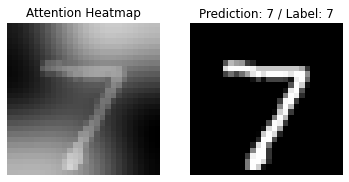

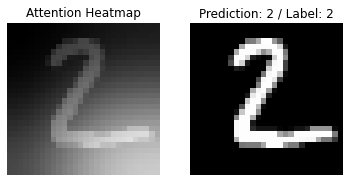

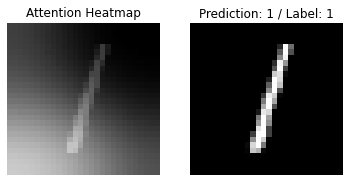

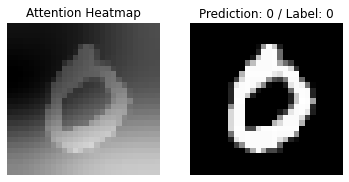

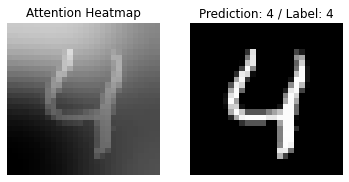

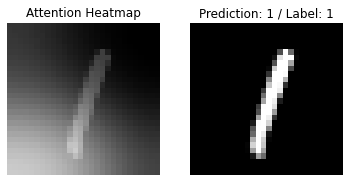

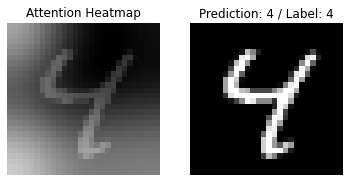

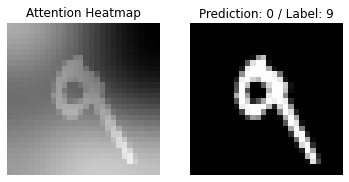

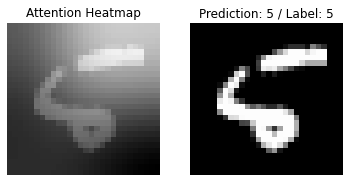

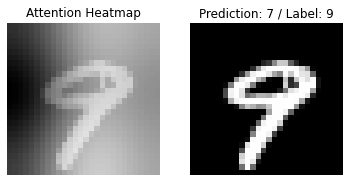

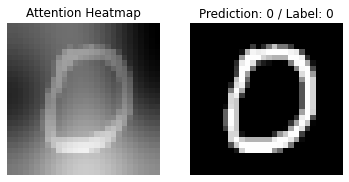

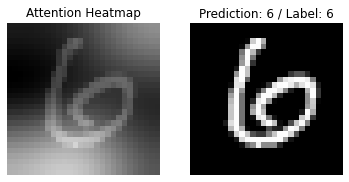

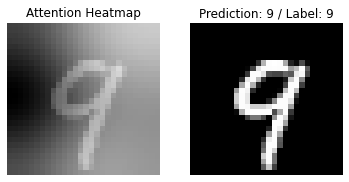

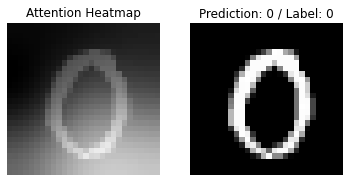

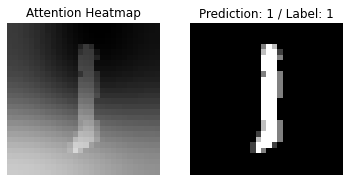

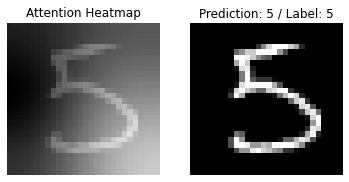

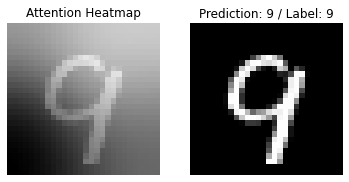

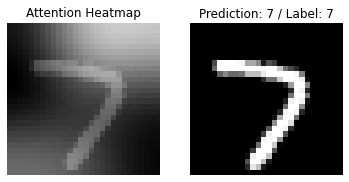

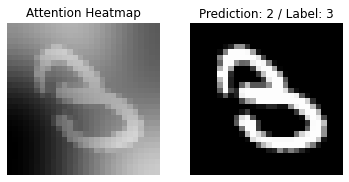

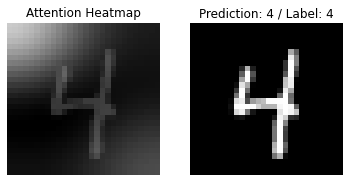

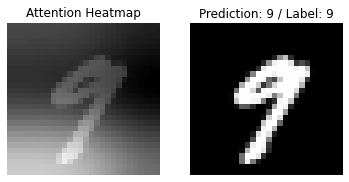

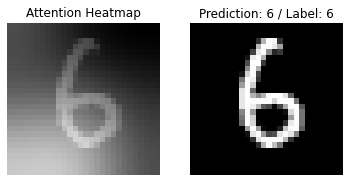

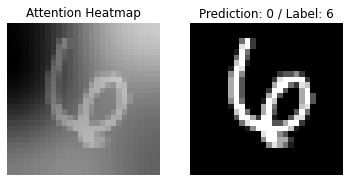

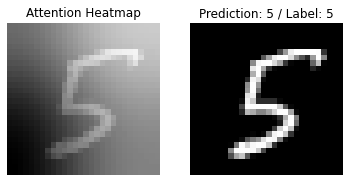

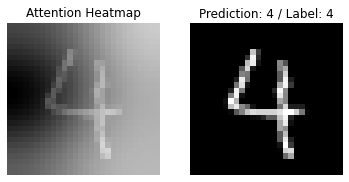

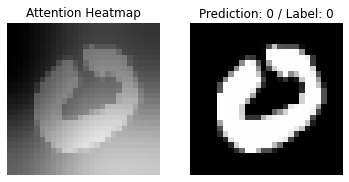

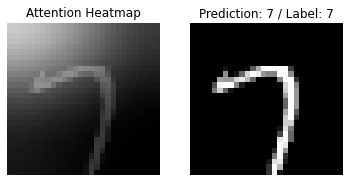

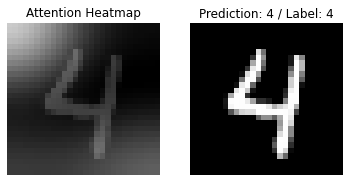

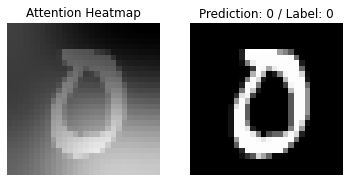

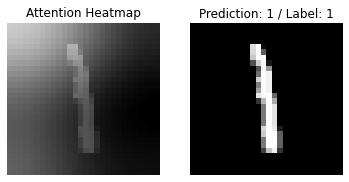

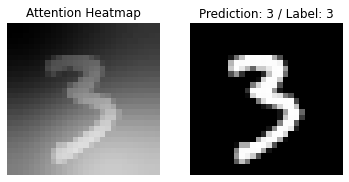

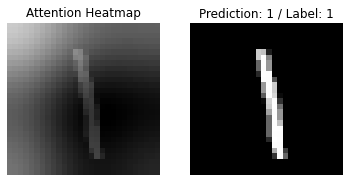

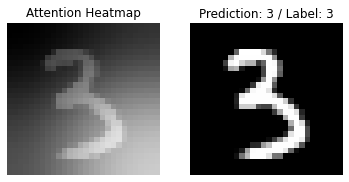

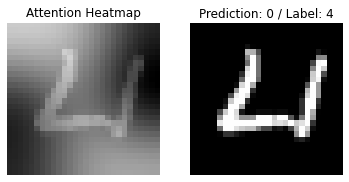

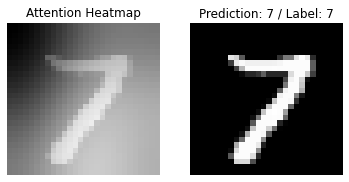

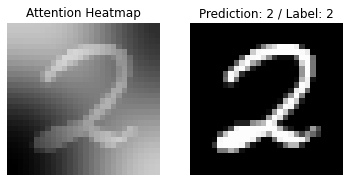

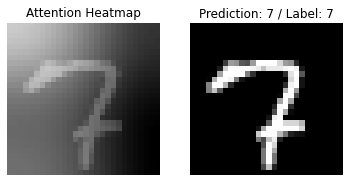

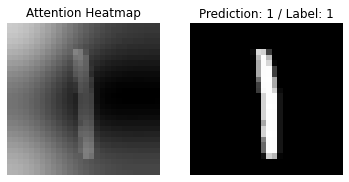

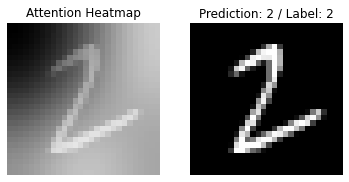

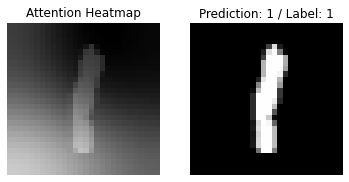

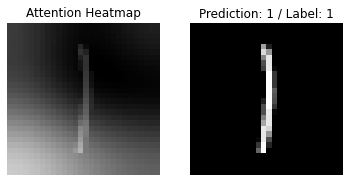

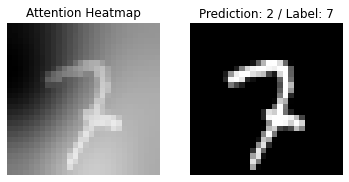

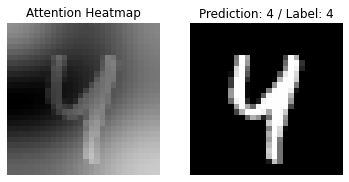

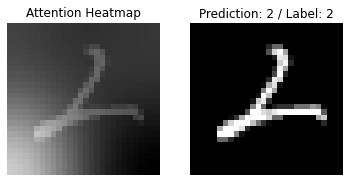

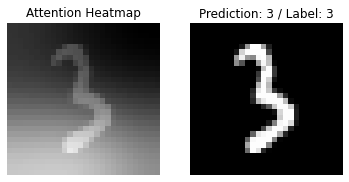

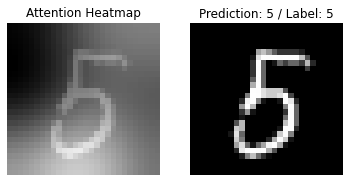

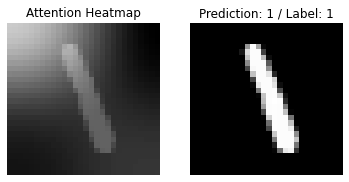

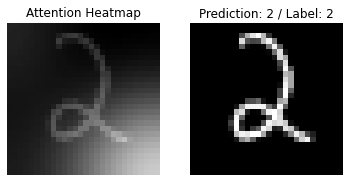

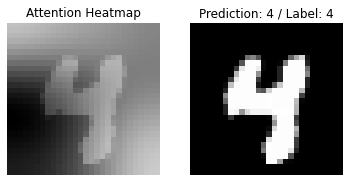

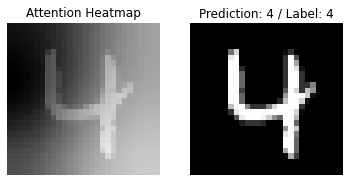

Sample Accuracy: 0.88


In [14]:
# Initialize fraction of test images and heatmap
test_fraction = np.zeros([10, img_size, img_size, 1])
heat_map = np.zeros([num_test_sample, img_size, img_size])

num_correct = 0.

# Test for Sampling data
for idx_sample in range(num_test_sample):
    
    # Get alpha(weight of fractions) and output for sample test data
    test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,1]))
    test_x_in = test_x_reshape[idx_sample,:,:,:]
    alpha_, output_ = sess.run([alpha, output],feed_dict = {x_image: [test_x_in], y_target: [test_y[idx_sample,:]]})
    alpha_size = int(np.sqrt(alpha_.shape[1]))
    alpha_reshape = np.reshape(alpha_, (alpha_size, alpha_size))
    alpha_resize = skimage.transform.pyramid_expand(alpha_reshape, upscale = 16, sigma=20)
    alpha_resize = cv2.resize(alpha_resize, dsize=(img_size,img_size), interpolation=cv2.INTER_LINEAR)
    
    # Make heatmap with alpha

    # Get labels for test samples
    y_test_pred = np.argmax(output_[:])
    y_test_true = np.argmax(test_y[idx_sample, :])
    
    # Draw subplot for each sample 
    f1, ax = plt.subplots(1,2)
    ax[0].imshow(test_x[idx_sample,:,:], cmap='gray')
    i = ax[0].imshow(alpha_resize,cmap="gray", alpha=0.8)
    ax[0].axis("off")
    ax[0].set_title('Attention Heatmap')
    
    ax[1].imshow(test_x[idx_sample,:,:], cmap='gray')
    ax[1].axis("off")
    ax[1].set_title('Prediction: ' + str(y_test_pred) + ' / ' + 'Label: ' + str(y_test_true))

    # Count correct
    if y_test_pred == y_test_true:
        num_correct += 1.

# Show results 
plt.show()
print('Sample Accuracy: ' + str(num_correct / num_test_sample))